In [1]:
# import packages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

In [2]:
train = pd.read_excel('lendingclub_traindata.xlsx')
validation=pd.read_excel('lendingclub_valdata.xlsx')
test = pd.read_excel('lendingclub_testdata.xlsx')

# 1 = good, 0 = default

#give column names
cols = ['home_ownership', 'income', 'dti', 'fico', 'loan_status']

train.columns = validation.columns=test.columns = cols
print("Training set")
print(train.head())
print("Validation set")
print (validation.head())
print("Test set")
print(test.head())

Training set
   home_ownership    income    dti  fico  loan_status
0               1   44304.0  18.47   690            0
1               0   50000.0  29.62   735            1
2               0   64400.0  16.68   675            1
3               0   38500.0  33.73   660            0
4               1  118000.0  26.66   665            1
Validation set
   home_ownership    income    dti  fico  loan_status
0               0   25000.0  27.60   660            0
1               0   50000.0  21.51   715            1
2               1  100000.0   8.14   770            1
3               0   75000.0   1.76   685            0
4               1   78000.0  16.11   680            1
Test set
   home_ownership    income    dti  fico  loan_status
0               1   52400.0  24.64   665            1
1               1  150000.0  17.04   785            1
2               1  100000.0  20.92   710            1
3               0   97000.0  13.11   705            1
4               1  100000.0  24.08   685     

The data has already been split into training set, validation set, and test set. There are 7000 instances of the training set, 3000 instances of the validation set and 2290 instances of the test set. The four features have been labeled as: home ownership, income, dti and fico.

In [4]:
# remove target column to create feature only dataset
X_train = train.drop('loan_status', 1)
X_val=validation.drop('loan_status', 1)
X_test = test.drop('loan_status', 1)

X_train_unscaled = X_train
X_val_unscaled = X_val
X_test_unscaled = X_test

# Scale data using the mean and standard deviation of the training set. 
# This is not necessary for the simple logistic regression we will do here 
# but should be done if L1 or L2 regrularization is carried out
X_test=(X_test-X_train.mean())/X_train.std()
X_val=(X_val-X_train.mean())/X_train.std()
X_train=(X_train-X_train.mean())/X_train.std()

# store target column as y-variables 
y_train = train['loan_status']
y_val=validation['loan_status']
y_test = test['loan_status']


#print first five instances for each data set - unscaled
print("Unscaled data")
print("Training set")
print(X_train_unscaled.head())
print("Validation set")
print(X_val_unscaled.head())
print("Test set")
print(X_test_unscaled.head())


print(X_train_unscaled.shape, y_train.shape, X_val_unscaled.shape,y_val.shape, X_test_unscaled.shape, y_test.shape)
X_train_unscaled.columns

Unscaled data
Training set
   home_ownership    income    dti  fico
0               1   44304.0  18.47   690
1               0   50000.0  29.62   735
2               0   64400.0  16.68   675
3               0   38500.0  33.73   660
4               1  118000.0  26.66   665
Validation set
   home_ownership    income    dti  fico
0               0   25000.0  27.60   660
1               0   50000.0  21.51   715
2               1  100000.0   8.14   770
3               0   75000.0   1.76   685
4               1   78000.0  16.11   680
Test set
   home_ownership    income    dti  fico
0               1   52400.0  24.64   665
1               1  150000.0  17.04   785
2               1  100000.0  20.92   710
3               0   97000.0  13.11   705
4               1  100000.0  24.08   685
(7000, 4) (7000,) (3000, 4) (3000,) (2290, 4) (2290,)


Index(['home_ownership', 'income', 'dti', 'fico'], dtype='object')

In [5]:
freq = y_train.value_counts()           # count frequency of different classes in training swet
freq/sum(freq)*100                      # get percentage of above

1    79.171429
0    20.828571
Name: loan_status, dtype: float64

In [6]:
#Create an instance of logistic regression named lgstc_reg on unscaled data

lgstc_reg =  LogisticRegression(penalty="none",solver="newton-cg")     

# Fit logististic regression to training set

lgstc_reg.fit(X_train_unscaled, y_train)                                        # fit training data on logistic regression 


print(lgstc_reg.intercept_, lgstc_reg.coef_)                           # get the coefficients of each features

[-5.98082741] [[ 2.97659316e-01  6.17979317e-07 -3.65499148e-02  1.12603137e-02]]


When used on scaled data the model has a bias of 1.416 and coefficients of 0.145, 0.034, -0.324 and 0.363. We now test the model on the validation set.

In [7]:
# y_train_pred, y_val_pred, and y_test_pred are the predicted probabilities for the training set
# validation set and test set using the fitted logistic regression model

y_train_pred=lgstc_reg.predict_proba(X_train_unscaled)
y_val_pred=lgstc_reg.predict_proba(X_val_unscaled)
y_test_pred=lgstc_reg.predict_proba(X_test_unscaled)

# Calculate maximum likelihood for training set, validation set, and test set
 
mle_vector_train = np.log(np.where(y_train == 1, y_train_pred[:,1], y_train_pred[:,0])) # if y_train == 1 set y_train_pred[:,1] otherwise set y_train_pred[:,0] 
mle_vector_val = np.log(np.where(y_val == 1, y_val_pred[:,1], y_val_pred[:,0]))
mle_vector_test = np.log(np.where(y_test == 1, y_test_pred[:,1], y_test_pred[:,0]))

# Calculate cost functions from maximum likelihoods

cost_function_training=np.negative(np.sum(mle_vector_train)/len(y_train))
cost_function_val=np.negative(np.sum(mle_vector_val)/len(y_val))
cost_function_test=np.negative(np.sum(mle_vector_test)/len(y_test))

print('cost function training set =', cost_function_training)
print('cost function validation set =', cost_function_val)
print('cost function test set =', cost_function_test)

cost function training set = 0.49111475922103454
cost function validation set = 0.4861711930624396
cost function test set = 0.4847008607351808


<br> 
An analyst must decide on a criterion for predicting whether loan will be good or default. This involves specifying a threshold By default this threshold is set to 0.5, i.e., loans are separated into good and bad categories according to whether the probability of no default is greater or less than 0.5. However this does not work well for an imbalanced data set such as this. It would predict that all loans are good! We will look at the results for few other thresholds. 



In [9]:
THRESHOLD = [0.00, .75, .80, .85, 1.00]
# Create dataframe to store results
results = pd.DataFrame(columns=["THRESHOLD", "accuracy", "true pos rate", "true neg rate", "false pos rate", "precision", "f-score"]) # df to store results

# Create threshold row
results['THRESHOLD'] = THRESHOLD                                                                         
             
j = 0                                                                                                      

# Iterate over the 3 thresholds

for i in THRESHOLD:                                                                                       
    
    
    #lgstc_reg.fit(X_train, y_train)                                                                    
    
    
    # If prob for test set > threshold predict 1
    preds = np.where(lgstc_reg.predict_proba(X_test_unscaled)[:,1] > i, 1, 0)                                      
    
    
    # create confusion matrix 
    cm = (confusion_matrix(y_test, preds,labels=[1, 0], sample_weight=None) / len(y_test))*100                   # confusion matrix (in percentage)
    
    print('Confusion matrix for threshold =',i)
    print(cm)
    print(' ')      
    
    TP = cm[0][0]                                                                                          # True Positives
    FN = cm[0][1]                                                                                          # False Positives
    FP = cm[1][0]                                                                                          # True Negatives
    TN = cm[1][1]                                                                                          # False Negatives
        
    results.iloc[j,1] = accuracy_score(y_test, preds) 
    results.iloc[j,2] = recall_score(y_test, preds)
    results.iloc[j,3] = TN/(FP+TN)                                                                         # True negative rate
    results.iloc[j,4] = FP/(FP+TN)                                                                         # False positive rate
    results.iloc[j,5] = precision_score(y_test, preds)
    results.iloc[j,6] = f1_score(y_test, preds)
   
   
    j += 1

print('ALL METRICS')
print( results.T)

Confusion matrix for threshold = 0.0
[[79.17030568  0.        ]
 [20.82969432  0.        ]]
 
Confusion matrix for threshold = 0.75
[[61.00436681 18.16593886]
 [11.70305677  9.12663755]]
 
Confusion matrix for threshold = 0.8
[[42.70742358 36.4628821 ]
 [ 6.41921397 14.41048035]]
 
Confusion matrix for threshold = 0.85
[[22.44541485 56.72489083]
 [ 3.01310044 17.81659389]]
 
Confusion matrix for threshold = 1.0
[[ 0.         79.17030568]
 [ 0.         20.82969432]]
 
ALL METRICS
                       0         1         2         3         4
THRESHOLD            0.0      0.75       0.8      0.85       1.0
accuracy        0.791703   0.70131  0.571179   0.40262  0.208297
true pos rate        1.0  0.770546  0.539437  0.283508       0.0
true neg rate        0.0  0.438155  0.691824  0.855346       1.0
false pos rate       1.0  0.561845  0.308176  0.144654       0.0
precision       0.791703  0.839039  0.869333  0.881647       0.0
f-score         0.883744  0.803335  0.665759  0.429048       

<br>
This table shows that there is a trade off betwee the true positive rate and the false positive rate.  
We can improve the percentage of good loans we identify only by increasing the percentage of bad that are misclassified.
The receiver operating curve (ROC) captures this trade off by considering different thresholds.

AUC random predictions = 0.5
AUC predictions from logistic regression model = 0.6191065921524141


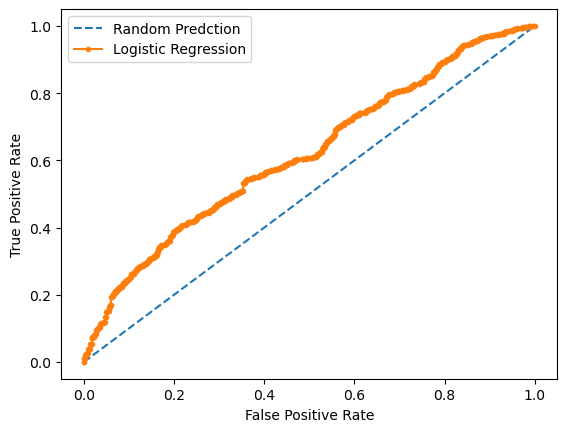

In [10]:

# Calculate the receiver operating curve and the AUC measure

lr_prob=lgstc_reg.predict_proba(X_test)
lr_prob=lr_prob[:, 1]
ns_prob=[0 for _ in range(len(y_test))]
ns_auc=roc_auc_score(y_test, ns_prob)
lr_auc=roc_auc_score(y_test,lr_prob)
print("AUC random predictions =", ns_auc)
print("AUC predictions from logistic regression model =", lr_auc)
ns_fpr,ns_tpr,_=roc_curve(y_test,ns_prob)
lr_fpr,lr_tpr,_=roc_curve(y_test,lr_prob)

plt.plot(ns_fpr,ns_tpr,linestyle='--',label='Random Predction')
plt.plot(lr_fpr,lr_tpr,marker='.',label='Logistic Regression')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()